In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


# Basic Importing


In [46]:
# show pipeline
from sklearn import set_config
# impute
from sklearn.impute import SimpleImputer
# pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from category_encoders import TargetEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
# models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier, plot_tree
# hyper parameter turning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from scipy.stats import uniform, randint
# feature selection
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
# metrics used
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, accuracy_score

# plotting imports
from pandas.plotting import boxplot
from pandas.plotting import bootstrap_plot
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

train_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
test_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')
sample_submission_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/sample_submission.csv')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore', category=DeprecationWarning)


# Data Overview

In [3]:
train_df.columns


Index(['MachineID', 'ProductName', 'EngineVersion', 'AppVersion',
       'SignatureVersion', 'IsBetaUser', 'RealTimeProtectionState',
       'IsPassiveModeEnabled', 'AntivirusConfigID',
       'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled',
       'HasTpm', 'CountryID', 'CityID', 'GeoRegionID', 'LocaleEnglishNameID',
       'PlatformType', 'Processor', 'OSVersion', 'OSBuildNumber',
       'OSProductSuite', 'OsPlatformSubRelease', 'OSBuildLab',
       'SKUEditionName', 'IsSystemProtected', 'AutoSampleSubmissionEnabled',
       'SMode', 'IEVersionID', 'FirewallEnabled', 'EnableLUA',
       'MDC2FormFactor', 'DeviceFamily', 'OEMNameID', 'OEMModelID',
       'ProcessorCoreCount', 'ProcessorManufacturerID', 'ProcessorModelID',
       'PrimaryDiskCapacityMB', 'PrimaryDiskType', 'SystemVolumeCapacityMB',
       'HasOpticalDiskDrive', 'TotalPhysicalRAMMB', 'ChassisType',
       'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal',
       'PrimaryDisplayResolutio

In [4]:
train_df.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,LocaleEnglishNameID,PlatformType,Processor,OSVersion,OSBuildNumber,OSProductSuite,OsPlatformSubRelease,OSBuildLab,SKUEditionName,IsSystemProtected,AutoSampleSubmissionEnabled,SMode,IEVersionID,FirewallEnabled,EnableLUA,MDC2FormFactor,DeviceFamily,OEMNameID,OEMModelID,ProcessorCoreCount,ProcessorManufacturerID,ProcessorModelID,PrimaryDiskCapacityMB,PrimaryDiskType,SystemVolumeCapacityMB,HasOpticalDiskDrive,TotalPhysicalRAMMB,ChassisType,PrimaryDisplayDiagonalInches,PrimaryDisplayResolutionHorizontal,PrimaryDisplayResolutionVertical,PowerPlatformRole,InternalBatteryNumberOfCharges,NumericOSVersion,OSArchitecture,OSBranch,OSBuildNumberOnly,OSBuildRevisionOnly,OSEdition,OSSkuFriendlyName,OSInstallType,OSInstallLanguageID,OSUILocaleID,AutoUpdateOptionsName,IsPortableOS,OSGenuineState,LicenseActivationChannel,IsFlightsDisabled,FlightRing,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,1.0,1,51,120232.0,98.0,103,windows10,x86,10.0.0.0,14393,768,rs1,14393.2214.x86fre.rs1_release_1.180402-1758,Home,1.0,0,0.0,98.0,1.0,1.0,SmallTablet,Windows.Desktop,561.0,330367.0,4.0,5.0,1850.0,15028.0,SSD,14348.0,0,1024.0,Notebook,8.0,800.0,1280.0,Slate,1.420000e+02,10.0.14393.2214,x86,rs1_release,14393,2214,Core,CORE,Update,5.0,26,UNKNOWN,0,IS_GENUINE,Retail,0.0,Retail,513.0,21964.0,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,1.0,1,141,112854.0,167.0,227,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,0.0,137.0,1.0,1.0,AllInOne,Windows.Desktop,2668.0,25212.0,4.0,5.0,2407.0,953869.0,HDD,952592.0,1,4096.0,AllinOne,19.4,1600.0,900.0,Desktop,4.294967e+09,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,9.0,34,FullAuto,0,IS_GENUINE,OEM:DM,0.0,Retail,628.0,44548.0,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,1.0,1,51,41759.0,98.0,103,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,0.0,137.0,1.0,1.0,Desktop,Windows.Desktop,3035.0,263666.0,4.0,5.0,2719.0,228936.0,SSD,228321.0,1,8192.0,Desktop,24.0,1920.0,1080.0,Desktop,4.294967e+09,10.0.17134.285,amd64,rs4_release,17134,285,Core,CORE,Reset,5.0,26,FullAuto,0,IS_GENUINE,OEM:NONSLP,0.0,Retail,142.0,9414.0,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,1.0,1,68,19507.0,276.0,74,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,0.0,108.0,1.0,1.0,Notebook,Windows.Desktop,2102.0,242491.0,4.0,5.0,3410.0,1907729.0,HDD,1890776.0,0,8192.0,Notebook,15.5,1366.0,768.0,Mobile,0.000000e+00,10.0.15063.850,amd64,rs2_release,15063,850,Core,CORE,Upgrade,7.0,30,UNKNOWN,0,IS_GENUINE,OEM:DM,0.0,Retail,554.0,33060.0,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,1.0,1,43,117801.0,53.0,42,windows10,x86,10.0.0.0,17134,256,rs4,17134.1.x86fre.rs4_release.180410-1804,Pro,1.0,0,0.0,137.0,1.0,1.0,Desktop,Windows.Desktop,2668.0,257309.0,2.0,5.0,4322.0,305245.0,HDD,52804.0,0,2048.0,Desktop,20.0,1600.0,900.0,Desktop,4.294967e+09,10.0.17134.285,x86,rs4_release,17134,285,Professional,PROFESSIONAL,UUPUpgrade,37.0,158,FullAuto,0,IS_GENUINE,Retail,0.0,Retail,628.0

In [5]:
train_df.shape

(100000, 76)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

In [7]:
train_df.describe()

,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,LocaleEnglishNameID,OSBuildNumber,OSProductSuite,IsSystemProtected,AutoSampleSubmissionEnabled,SMode,IEVersionID,FirewallEnabled,EnableLUA,OEMNameID,OEMModelID,ProcessorCoreCount,ProcessorManufacturerID,ProcessorModelID,PrimaryDiskCapacityMB,SystemVolumeCapacityMB,HasOpticalDiskDrive,TotalPhysicalRAMMB,PrimaryDisplayDiagonalInches,PrimaryDisplayResolutionHorizontal,PrimaryDisplayResolutionVertical,InternalBatteryNumberOfCharges,OSBuildNumberOnly,OSBuildRevisionOnly,OSInstallLanguageID,OSUILocaleID,IsPortableOS,IsFlightsDisabled,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,target
count,100000.0,99934.000000,100000.000000,99924.000000,99924.000000,99924.000000,100000.000000,100000.000000,99377.000000,100000.000000,100000.000000,100000.000000,100000.000000,99924.000000,100000.0,99019.000000,99893.000000,99834.000000,99981.000000,99788.000000,99772.000000,99915.000000,99915.000000,99915.000000,9.989000e+04,9.989000e+04,100000.00000,99849.000000,99928.000000,99928.000000,99928.000000,9.948500e+04,100000.000000,100000.000000,99887.000000,100000.000000,100000.000000,99674.0,99624.000000,99666.000000,100000.000000,99980.000000,100000.000000,100000.000000,99866.000000,99441.000000,99441.000000,100000.000000
mean,0.0,6.848430,0.017620,47975.710440,1.326528,1.018264,0.996780,108.078790,81029.938587,169.741630,122.695100,15917.208720,578.403380,0.955326,0.0,0.000505,124.053848,0.980067,0.996569,2209.573265,238780.914154,4.011500,4.530711,2367.693069,5.158619e+05,3.819905e+05,0.08140,6132.087442,16.708674,1552.230416,898.253192,1.118069e+09,15990.596350,986.531360,14.519267,60.030870,0.000520,0.0,401.987613,32942.648044,0.495690,0.003841,0.128470,0.040580,0.058398,0.296668,7.875866,0.505250
std,0.0,1.015166,0.131566,13803.321533,0.520681,0.155291,0.056654,63.062151,48944.027074,89.188929,69.242252,1943.421132,247.240971,0.206588,0.0,0.022466,33.535395,0.139771,0.266669,1300.863891,71708.483379,2.033075,1.288050,837.822392,3.525624e+05,3.246240e+05,0.27345,4813.882548,6.031598,363.438980,213.695880,1.884682e+09,1810.756601,2971.429862,10.142233,44.715508,0.022798,0.0,221.318891,21151.970827,0.499984,0.061855,0.334614,0.197316,0.234496,0.456791,4.562533,0.499975
min,0.0,0.000000,0.000000,39.000000,1.000000,0.000000,0.000000,1.000000,7.000000,1.000000,1.000000,7601.000000,16.000000,0.000000,0.0,0.000000,39.000000,0.000000,0.000000,46.000000,22.000000,1.000000,1.000000,3.000000,1.228800e+04,1.088000e+04,0.00000,512.000000,5.300000,400.000000,300.000000,0.000000e+00,10240.000000,0.000000,1.000000,5.000000,0.000000,0.0,2.000000,121.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.0,7.000000,0.000000,49480.000000,1.000000,1.000000,1.000000,51.000000,36694.000000,89.000000,74.000000,16299.000000,256.000000,1.000000,0.0,0.000000,111.000000,1.000000,1.000000,1443.000000,189586.000000,2.000000,5.000000,1998.000000,2.441980e+05,1.208410e+05,0.00000,4096.000000,13.900000,1366.000000,768.000000,0.000000e+00,16299.000000,167.000000,8.000000,31.000000,0.000000,0.0,142.000000,13020.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,0.0,7.000000,0.000000,53447.000000,1.000000,1.000000,1.000000,97.000000,82373.000000,181.000000,88.000000,16299.000000,768.000000,1.000000,0.0,0.000000,135.000000,1.000000,1.000000,2102.000000,246528.000000,4.000000,5.000000,2503.000000,4.769400e+05,2.567655e+05,0.00000,4096.000000,15.500000,1366.000000,768.000000,0.000000e+00,16299.000000,285.000000,9.000000,34.000000,0.000000,0.0,500.000000,33066.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000
75%,0.0,7.000000,0.000000,53447.000000,2.000000,1.000000,1.000000,162.000000,122835.000000,267.000000,182

In [8]:
train_df.describe(include="object")

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,PlatformType,Processor,OSVersion,OsPlatformSubRelease,OSBuildLab,SKUEditionName,MDC2FormFactor,DeviceFamily,PrimaryDiskType,ChassisType,PowerPlatformRole,NumericOSVersion,OSArchitecture,OSBranch,OSEdition,OSSkuFriendlyName,OSInstallType,AutoUpdateOptionsName,OSGenuineState,LicenseActivationChannel,FlightRing,DateAS,DateOS
count,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,99977,99998,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,99976
unique,99835,2,37,69,2735,4,3,7,9,281,8,11,2,4,28,9,221,3,13,20,18,9,6,4,6,7,2695,112
top,8e0523438a5ca48323f50b2c47f6d31a,win8defender,1.1.15200.1,4.18.1807.18075,1.273.1420.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,Notebook,Windows.Desktop,HDD,Notebook,Mobile,10.0.17134.228,amd64,rs4_release,Core,CORE,UUPUpgrade,FullAuto,IS_GENUINE,Retail,Retail,2018-08-15 06:29:00,2018-08-14
freq,2,99771,45219,62119,1274,98344,91262,98368,45837,42964,62863,64547,99971,66202,59459,69874,17069,91281,46909,39275,39273,32033,45154,89860,52195,94153,1274,20905


In [9]:
print(train_df.isnull().sum())


MachineID                               0
ProductName                             0
EngineVersion                           0
AppVersion                              0
SignatureVersion                        0
IsBetaUser                              0
RealTimeProtectionState                66
IsPassiveModeEnabled                    0
AntivirusConfigID                      76
NumAntivirusProductsInstalled          76
NumAntivirusProductsEnabled            76
HasTpm                                  0
CountryID                               0
CityID                                623
GeoRegionID                             0
LocaleEnglishNameID                     0
PlatformType                            0
Processor                               0
OSVersion                               0
OSBuildNumber                           0
OSProductSuite                          0
OsPlatformSubRelease                    0
OSBuildLab                              0
SKUEditionName                    

In [10]:
print(f'There are {train_df.isnull().any().sum()} columns in train dataset with missing values.')
print("Total Null Values :",train_df.isnull().sum().sum())
print("Total Duplicated Rows :", train_df.duplicated().sum())

There are 33 columns in train dataset with missing values.
Total Null Values : 6533
Total Duplicated Rows : 165


In [11]:
numeric_cols = train_df.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

In [13]:
print("Total Numeric Columns :", len(numeric_cols))
print("Total Categorical Columns :", len(categorical_cols))

Total Numeric Columns : 48
Total Categorical Columns : 28


In [14]:
numeric_cols

['IsBetaUser',
 'RealTimeProtectionState',
 'IsPassiveModeEnabled',
 'AntivirusConfigID',
 'NumAntivirusProductsInstalled',
 'NumAntivirusProductsEnabled',
 'HasTpm',
 'CountryID',
 'CityID',
 'GeoRegionID',
 'LocaleEnglishNameID',
 'OSBuildNumber',
 'OSProductSuite',
 'IsSystemProtected',
 'AutoSampleSubmissionEnabled',
 'SMode',
 'IEVersionID',
 'FirewallEnabled',
 'EnableLUA',
 'OEMNameID',
 'OEMModelID',
 'ProcessorCoreCount',
 'ProcessorManufacturerID',
 'ProcessorModelID',
 'PrimaryDiskCapacityMB',
 'SystemVolumeCapacityMB',
 'HasOpticalDiskDrive',
 'TotalPhysicalRAMMB',
 'PrimaryDisplayDiagonalInches',
 'PrimaryDisplayResolutionHorizontal',
 'PrimaryDisplayResolutionVertical',
 'InternalBatteryNumberOfCharges',
 'OSBuildNumberOnly',
 'OSBuildRevisionOnly',
 'OSInstallLanguageID',
 'OSUILocaleID',
 'IsPortableOS',
 'IsFlightsDisabled',
 'FirmwareManufacturerID',
 'FirmwareVersionID',
 'IsSecureBootEnabled',
 'IsVirtualDevice',
 'IsTouchEnabled',
 'IsPenCapable',
 'IsAlwaysOnAlway

In [15]:
categorical_cols

['MachineID',
 'ProductName',
 'EngineVersion',
 'AppVersion',
 'SignatureVersion',
 'PlatformType',
 'Processor',
 'OSVersion',
 'OsPlatformSubRelease',
 'OSBuildLab',
 'SKUEditionName',
 'MDC2FormFactor',
 'DeviceFamily',
 'PrimaryDiskType',
 'ChassisType',
 'PowerPlatformRole',
 'NumericOSVersion',
 'OSArchitecture',
 'OSBranch',
 'OSEdition',
 'OSSkuFriendlyName',
 'OSInstallType',
 'AutoUpdateOptionsName',
 'OSGenuineState',
 'LicenseActivationChannel',
 'FlightRing',
 'DateAS',
 'DateOS']

In [16]:
train_df["IsBetaUser"].value_counts()

IsBetaUser
0    100000
Name: count, dtype: int64

In [17]:
train_df["IsPassiveModeEnabled"].value_counts()

IsPassiveModeEnabled
0    98238
1     1762
Name: count, dtype: int64

In [18]:
train_df["AutoSampleSubmissionEnabled"].value_counts()

AutoSampleSubmissionEnabled
0    100000
Name: count, dtype: int64

In [19]:
train_df["IsFlightsDisabled"].value_counts()

IsFlightsDisabled
0.0    99674
Name: count, dtype: int64

**Dropping Columns** - ["IsBetaUser","AutoSampleSubmissionEnabled","IsFlightsDisabled"]

# Exploratory Data Analysis (EDA)

Firstly lets delete Columns

In [47]:
columns_to_drop = ["IsBetaUser","AutoSampleSubmissionEnabled","IsFlightsDisabled","MachineID"]
train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)

In [48]:
numeric_cols = train_df.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

In [22]:
len(numeric_cols)

45

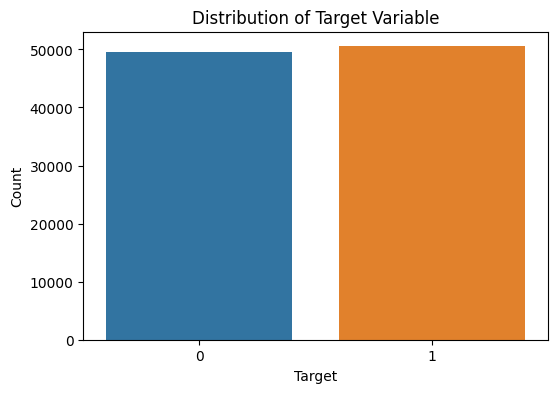

In [23]:
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='target')
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


In [24]:
correlations = train_df[numeric_cols].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)


,level_0,level_1,0
45,OSUILocaleID,OSInstallLanguageID,0.988082
46,OSInstallLanguageID,OSUILocaleID,0.988082
47,OSBuildNumberOnly,OSBuildNumber,0.947564
48,OSBuildNumber,OSBuildNumberOnly,0.947564
49,RealTimeProtectionState,IsPassiveModeEnabled,0.901426
50,IsPassiveModeEnabled,RealTimeProtectionState,0.901426
51,PrimaryDisplayResolutionHorizontal,PrimaryDisplayResolutionVertical,0.898174
52,PrimaryDisplayResolutionVertical,PrimaryDisplayResolutionHorizontal,0.898174
53,ProcessorManufacturerID,ProcessorModelID,0.801885
54,ProcessorModelID,ProcessorManufacturerID,0.801885


In [25]:
correlation_matrix = train_df[numeric_cols].corr()

threshold = 0.9
highly_correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

highly_correlated_features

{'IsPassiveModeEnabled', 'OSBuildNumberOnly', 'OSUILocaleID'}

In [26]:
correlation_with_target = train_df[numeric_cols].corrwith(train_df['target']).sort_values(ascending=False)
print("Top 10 Positively Correlated Features:\n", correlation_with_target.head(10))
print("All 15 Negatively Correlated Features:\n", correlation_with_target.tail(15))


Top 10 Positively Correlated Features:
 target                          1.000000
AntivirusConfigID               0.118304
TotalPhysicalRAMMB              0.065747
IsSystemProtected               0.062401
IsGamer                         0.061191
ProcessorCoreCount              0.056769
PrimaryDiskCapacityMB           0.049117
RealTimeProtectionState         0.049012
OSBuildNumberOnly               0.038544
PrimaryDisplayDiagonalInches    0.035064
dtype: float64
All 15 Negatively Correlated Features:
 EnableLUA                          -0.001928
CityID                             -0.004596
OSBuildRevisionOnly                -0.008076
OEMNameID                          -0.011749
SMode                              -0.015559
RegionIdentifier                   -0.019559
IsPenCapable                       -0.019797
OSProductSuite                     -0.020313
FirmwareManufacturerID             -0.020420
IsVirtualDevice                    -0.039789
NumAntivirusProductsEnabled        -0.041547


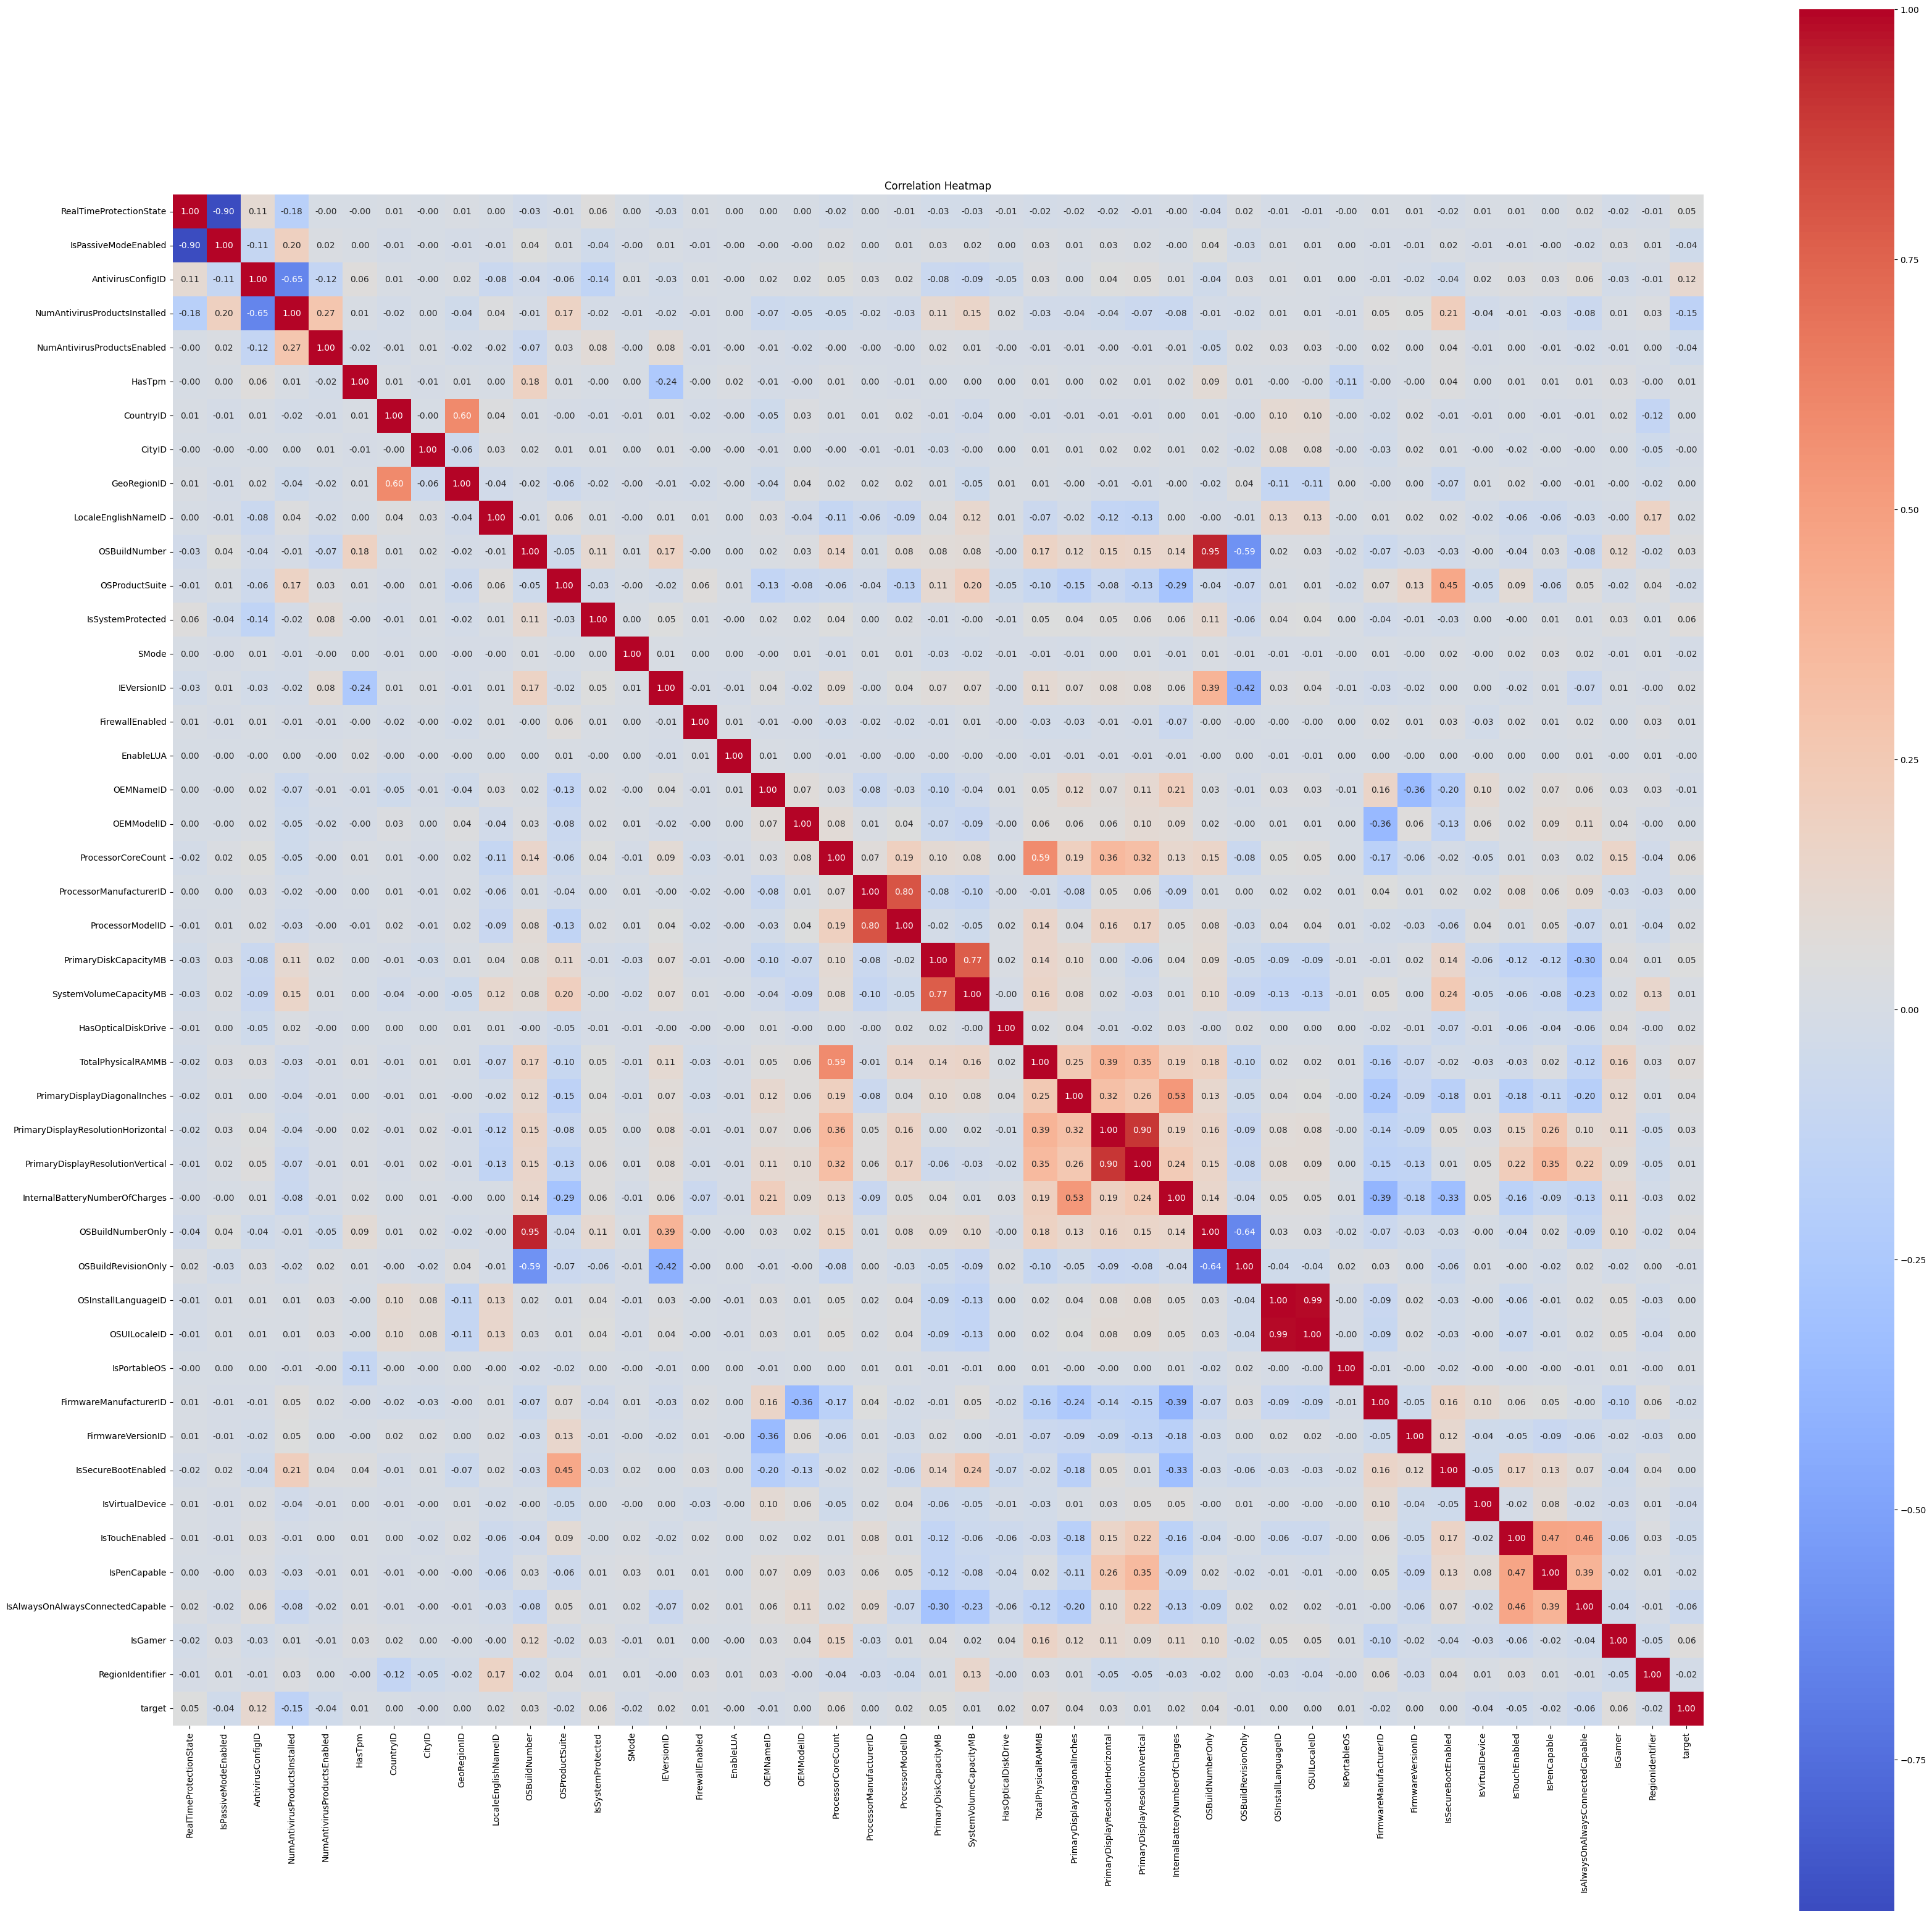

CPU times: user 5.62 s, sys: 355 ms, total: 5.97 s
Wall time: 5.76 s


In [27]:
%%time
plt.figure(figsize=(40,40))
sns.heatmap(train_df[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()


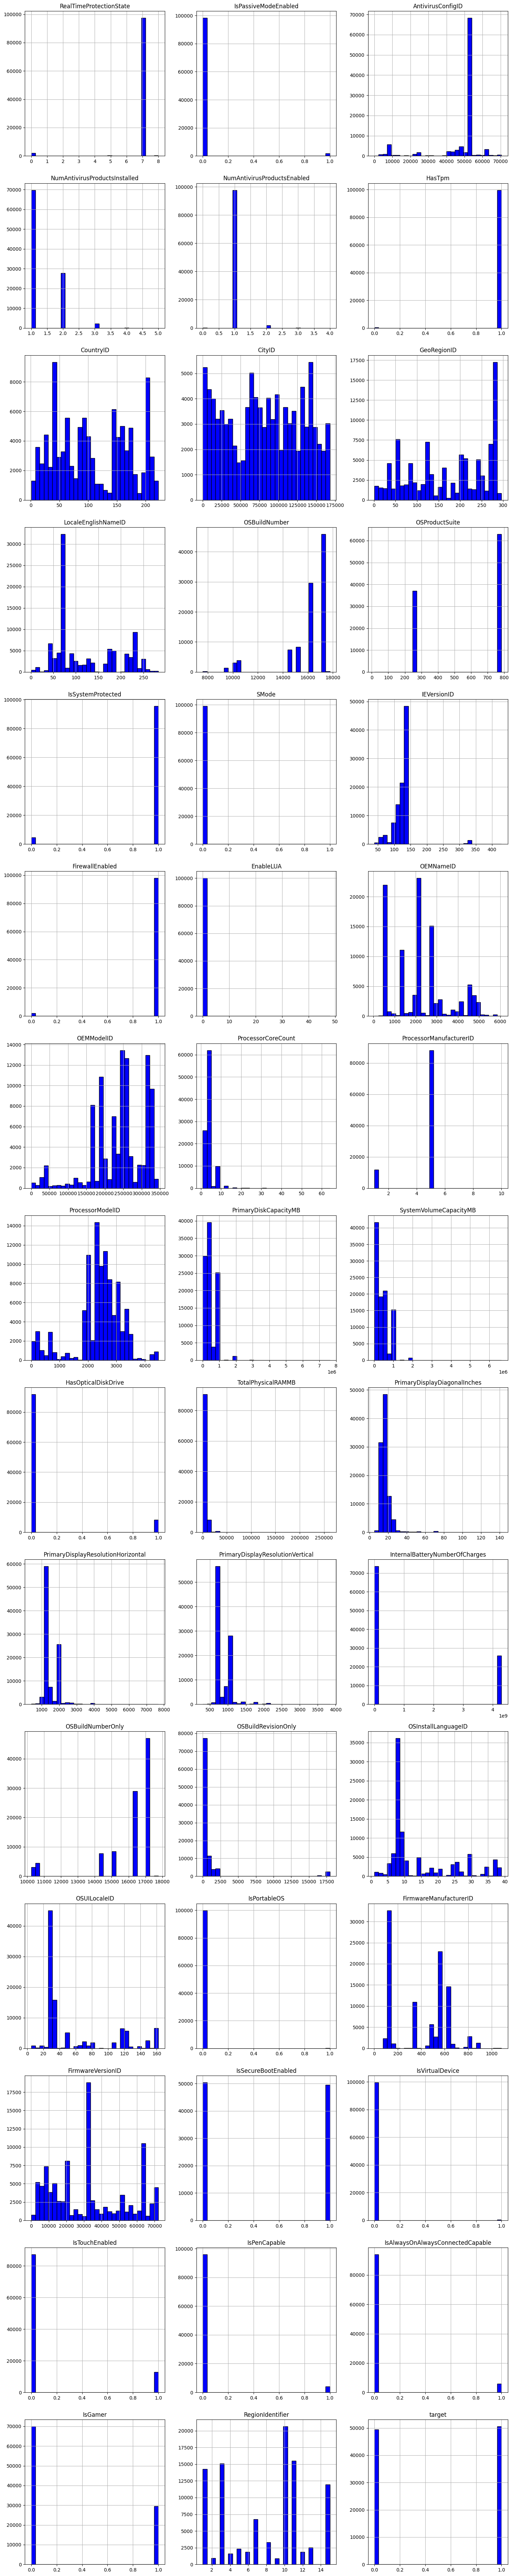

In [28]:
num_columns = train_df.select_dtypes(include=['number']).columns

# Define grid size
num_features = len(num_columns)
rows = int(np.ceil(num_features / 3))  # 3 columns per row

# Create subplots
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(num_columns):
    train_df[col].hist(ax=axes[i], bins=30, color='blue', edgecolor='black')
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

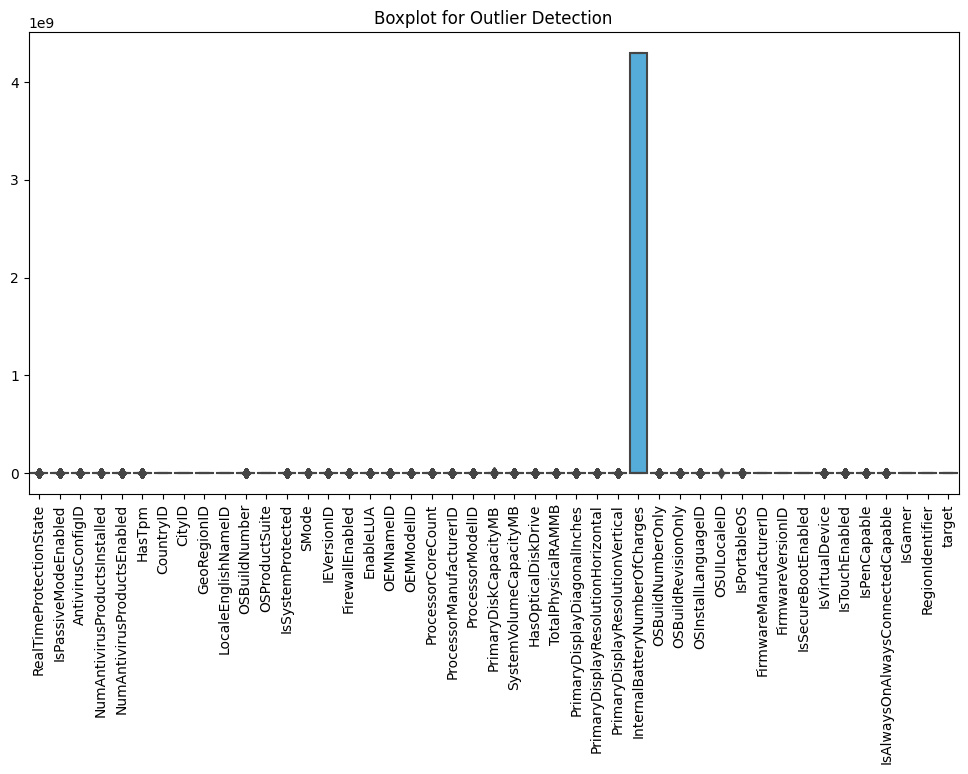

In [28]:
 
plt.figure(figsize=(12,6))
sns.boxplot(data=train_df[numeric_cols])
plt.xticks(rotation=90)
plt.title("Boxplot for Outlier Detection")
plt.show()


In [29]:
train_df['InternalBatteryNumberOfCharges']

0        1.420000e+02
1        4.294967e+09
2        4.294967e+09
3        0.000000e+00
4        4.294967e+09
             ...     
99995    4.294967e+09
99996    0.000000e+00
99997    4.294967e+09
99998    4.500000e+01
99999    0.000000e+00
Name: InternalBatteryNumberOfCharges, Length: 100000, dtype: float64

In [30]:
train_df['InternalBatteryNumberOfCharges'].value_counts()

InternalBatteryNumberOfCharges
0.000000e+00    58047
4.294967e+09    25788
1.000000e+00      540
2.000000e+00      312
1.600000e+01      288
                ...  
1.080000e+03        1
3.903700e+04        1
5.490000e+02        1
2.565000e+03        1
7.968000e+03        1
Name: count, Length: 1760, dtype: int64

# Data Preprocessing & Feature Engineering

In [49]:
# handling date columns 

train_df['DateAS'] = pd.to_datetime(train_df['DateAS'])
train_df['DateOS'] = pd.to_datetime(train_df['DateOS'])

In [50]:
train_df['AS_year'] = train_df['DateAS'].dt.year
train_df['AS_month'] = train_df['DateAS'].dt.month
train_df['AS_day'] = train_df['DateAS'].dt.day
train_df['AS_hour'] = train_df['DateAS'].dt.hour
train_df['AS_dayofweek'] = train_df['DateAS'].dt.dayofweek  # Monday=0, Sunday=6

train_df['OS_year'] = train_df['DateOS'].dt.year
train_df['OS_month'] = train_df['DateOS'].dt.month
train_df['OS_day'] = train_df['DateOS'].dt.day

# Compute time difference in days
train_df['days_diff'] = (train_df['DateAS'] - train_df['DateOS']).dt.days

# Cyclical encoding for months and days
train_df['AS_month_sin'] = np.sin(2 * np.pi * train_df['AS_month'] / 12)
train_df['AS_month_cos'] = np.cos(2 * np.pi * train_df['AS_month'] / 12)
train_df['AS_day_sin'] = np.sin(2 * np.pi * train_df['AS_day'] / 31)
train_df['AS_day_cos'] = np.cos(2 * np.pi * train_df['AS_day'] / 31)

train_df.drop(columns=['DateAS', 'DateOS'], inplace=True)



In [51]:
X = train_df.drop(columns=['target']) 
y = train_df['target']

In [52]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [53]:
num_imputer = SimpleImputer(strategy='mean')
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

In [54]:
X.describe(include="object")

,ProductName,EngineVersion,AppVersion,SignatureVersion,PlatformType,Processor,OSVersion,OsPlatformSubRelease,OSBuildLab,SKUEditionName,MDC2FormFactor,DeviceFamily,PrimaryDiskType,ChassisType,PowerPlatformRole,NumericOSVersion,OSArchitecture,OSBranch,OSEdition,OSSkuFriendlyName,OSInstallType,AutoUpdateOptionsName,OSGenuineState,LicenseActivationChannel,FlightRing
count,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
unique,2,37,69,2735,4,3,7,9,281,8,11,2,4,28,9,221,3,13,20,18,9,6,4,6,7
top,win8defender,1.1.15200.1,4.18.1807.18075,1.273.1420.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,Notebook,Windows.Desktop,HDD,Notebook,Mobile,10.0.17134.228,amd64,rs4_release,Core,CORE,UUPUpgrade,FullAuto,IS_GENUINE,Retail,Retail
freq,99771,45219,62119,1274,98344,91262,98368,45837,42964,62863,64547,99971,66225,59461,69874,17069,91281,46909,39275,39273,32033,45154,89860,52195,94153


In [55]:
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [56]:
# label encoding

binary_cols = ['ProductName', 'DeviceFamily']
for col in binary_cols:
    X[col] = X[col].astype('category').cat.codes


In [57]:
#  one hot encoding

low_cardinality_cols = ['Processor', 'PrimaryDiskType', 'OSArchitecture', 'OSGenuineState']
X = pd.get_dummies(X, columns=low_cardinality_cols, drop_first=True)

In [58]:
#  target encoding

medium_cardinality_cols = ['PlatformType', 'OsPlatformSubRelease', 'SKUEditionName', 'ChassisType', 
                           'PowerPlatformRole', 'OSEdition', 'OSSkuFriendlyName', 'OSInstallType', 
                           'AutoUpdateOptionsName', 'LicenseActivationChannel', 'FlightRing']

target_col = 'target'  
encoder = TargetEncoder()
X[medium_cardinality_cols] = encoder.fit_transform(X[medium_cardinality_cols], y)

In [59]:
high_cardinality_cols = ['EngineVersion', 'AppVersion', 'SignatureVersion', 'OSVersion', 
                         'OSBuildLab', 'MDC2FormFactor', 'NumericOSVersion', 'OSBranch']

for col in high_cardinality_cols:
    X[col + '_freq'] = X[col].map(X[col].value_counts() / len(X))

# Drop original high-cardinality columns
X.drop(columns=high_cardinality_cols, inplace=True)


**Pipeline**

In [ ]:
# Pipeline


binary_cols = ['ProductName', 'DeviceFamily']
low_cardinality_cols = ['Processor', 'PrimaryDiskType', 'OSArchitecture', 'OSGenuineState']
medium_cardinality_cols = ['PlatformType', 'OsPlatformSubRelease', 'SKUEditionName', 'ChassisType', 
                           'PowerPlatformRole', 'OSEdition', 'OSSkuFriendlyName', 'OSInstallType', 
                           'AutoUpdateOptionsName', 'LicenseActivationChannel', 'FlightRing']
high_cardinality_cols = ['EngineVersion', 'AppVersion', 'SignatureVersion', 'OSVersion', 
                         'OSBuildLab', 'MDC2FormFactor', 'NumericOSVersion', 'OSBranch']

def binary_encoding(X):
    X = X.copy()
    for col in binary_cols:
        X[col] = X[col].astype('category').cat.codes
    return X

def frequency_encoding(X):
    X = X.copy()
    for col in high_cardinality_cols:
        X[col + '_freq'] = X[col].map(X[col].value_counts() / len(X))
    return X.drop(columns=high_cardinality_cols)

# Create the column transformer
preprocessor = ColumnTransformer([
    ('binary_encoding', FunctionTransformer(binary_encoding), binary_cols),
    ('one_hot_encoding', OneHotEncoder(drop='first', handle_unknown='ignore'), low_cardinality_cols),
    ('target_encoding', TargetEncoder(), medium_cardinality_cols),
    ('frequency_encoding', FunctionTransformer(frequency_encoding), high_cardinality_cols)
], remainder='passthrough')

# Define pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor)
])

X = pipeline.fit_transform(X, y)

# Model Selection & Training

In [ ]:
# Dummy Clasifier

X=train_df.drop("target", axis=1)
y=train_df["target"]

from sklearn.dummy import DummyClassifier
model = DummyClassifier().fit(X,y)

y_pred = model.predict(test_df)
accuracy_score(y,y_pred)
submission = pd.DataFrame({
    "id": range(0,test_df.shape[0]),
    "target":y_pred
})
submission.to_csv("submission.csv", index=False)


In [60]:
X.head()

,ProductName,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,LocaleEnglishNameID,PlatformType,OSBuildNumber,OSProductSuite,OsPlatformSubRelease,SKUEditionName,IsSystemProtected,SMode,IEVersionID,FirewallEnabled,EnableLUA,DeviceFamily,OEMNameID,OEMModelID,ProcessorCoreCount,ProcessorManufacturerID,ProcessorModelID,PrimaryDiskCapacityMB,SystemVolumeCapacityMB,HasOpticalDiskDrive,TotalPhysicalRAMMB,ChassisType,PrimaryDisplayDiagonalInches,PrimaryDisplayResolutionHorizontal,PrimaryDisplayResolutionVertical,PowerPlatformRole,InternalBatteryNumberOfCharges,OSBuildNumberOnly,OSBuildRevisionOnly,OSEdition,OSSkuFriendlyName,OSInstallType,OSInstallLanguageID,OSUILocaleID,AutoUpdateOptionsName,IsPortableOS,LicenseActivationChannel,FlightRing,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,AS_year,AS_month,AS_day,AS_hour,AS_dayofweek,OS_year,OS_month,OS_day,days_diff,AS_month_sin,AS_month_cos,AS_day_sin,AS_day_cos,Processor_x64,Processor_x86,PrimaryDiskType_SSD,PrimaryDiskType_UNKNOWN,PrimaryDiskType_Unspecified,OSArchitecture_arm64,OSArchitecture_x86,OSGenuineState_IS_GENUINE,OSGenuineState_OFFLINE,OSGenuineState_UNKNOWN,EngineVersion_freq,AppVersion_freq,SignatureVersion_freq,OSVersion_freq,OSBuildLab_freq,MDC2FormFactor_freq,NumericOSVersion_freq,OSBranch_freq
0,1,0.149356,-0.133925,0.396528,-0.627359,-0.117656,0.056837,-0.905124,0.803468,-0.804382,-0.284439,0.505399,-0.784295,0.766853,0.457170,0.497638,0.21633,-0.022588,-0.777326,0.142732,0.012866,0,-1.268643,1.278665,-0.005659,0.364497,-0.618169,-1.421343,-1.133147,-0.297680,-1.061923,0.508064,-1.444369,-2.070513,1.787055,0.372619,-0.594777,-0.882286,0.413092,0.478421,0.478420,0.476024,-0.939112,-0.761057,0.496673,-0.022809,0.494051,0.505688,0.502543,-0.519908,-0.991417,-0.062099,2.604596,-0.205661,4.018138,-0.651288,-0.412302,2018,9,10,10,0,0.437312,-1.226806,0.900604,0.149723,-0.61456,1.214444,1.317987,-0.568898,False,True,True,False,False,False,True,True,False,False,0.45219,0.62119,0.00025,0.98368,0.00085,0.00351,0.00410,0.07780
1,1,0.149356,-0.133925,0.396528,-0.627359,-0.117656,0.056837,0.522046,0.652252,-0.030740,1.506384,0.505399,0.626111,-1.304011,0.529267,0.518390,0.21633,-0.022588,0.386253,0.142732,0.012866,0,0.352778,-2.981710,-0.005659,0.364497,0.046936,1.243044,1.758707,3.359317,-0.423283,0.515205,0.446367,0.131486,0.008177,0.524185,1.690008,0.631454,-0.255276,0.517109,0.517855,0.538882,-0.544497,-0.582147,0.524715,-0.022809,0.504084,0.505688,1.023137,0.549587,1.008657,-0.062099,-0.383937,-0.205661,-0.249205,-0.651288,0.466869,2018,8,16,0,3,0.437312,0.521576,0.274260,-0.633613,-0.24890,-0.312420,-0.111689,-1.345270,True,False,False,False,False,False,False,True,False,False,0.44017,0.62119,0.00106,0.98368,0.42964,0.03147,0.17069,0.46909
2,1,0.149356,-0.133925,0.396528,-0.627359,-0.117656,0.056837,-0.905124,-0.804879,-0.804382,-0.284439,0.505399,0.626111,0.766853,0.529267,0.497638,0.21633,-0.022588,0.386253,0.142732,0.012866,0,0.635199,0.347429,-0.005659,0.364497,0.419490,-0.814282,-0.473640,3.359317,0.428236,0.522913,1.209296,1.012285,0.850803,0.524185,1.690008,0.631454,-0.236093,0.478421,0.478420,0.489645,-0.939112,-0.761057,0.524715,-0.022809,0.544027,0.505688,-1.176940,-1.114230,-0.991417,-0.062099,-0.383937,-0.205661,-0.249205,1.544051,-0.412302,2018,9,20,23,3,0.437312,0.958671,-0.352083,-0.595534,-0.61456,1.214444,-1.098618,-0.809327,True,False,True,False,False,False,False,True,False,False,0.45219,0.62119,0.00133,0.98368,0.42964,0.21612,0.05255,0.46909
3,1,0.149356,-0.133925,-0.113256,1.293941,-0.117656,0.056837,-0.635547,-1.260946,1.191391,-0.703261,0.505399,-0.439541,0.766853,0.486390,0.497638,0.21633,-0.022588,-0.478972,0.142732,0.012866,0,-0.082782,0.051798,-0.005659,0.364497,1.244602,3.950053,4.650376,-0.297680,0.428236,0.508064,-0.200464,-0.5

In [61]:
%%time
# Logistic Regression model 
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(solver='liblinear', random_state=42)

# Train the model on the training data
log_reg_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = log_reg_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.60765
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.54      0.58      9878
           1       0.60      0.67      0.63     10122

    accuracy                           0.61     20000
   macro avg       0.61      0.61      0.61     20000
weighted avg       0.61      0.61      0.61     20000

CPU times: user 21.3 s, sys: 262 ms, total: 21.6 s
Wall time: 21.4 s


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.700455	valid_1's auc: 0.675867
Accuracy: 0.6274
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.57      0.60      9878
           1       0.62      0.68      0.65     10122

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



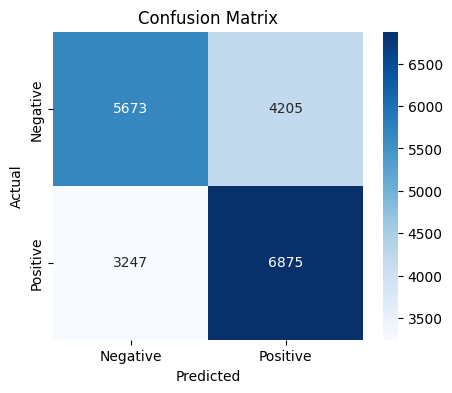

CPU times: user 12.1 s, sys: 223 ms, total: 12.4 s
Wall time: 3.8 s


In [62]:
%%time
#Lgb Model


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'objective': 'binary', 
    'metric': 'auc',  
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    num_boost_round=100,
    callbacks=[lgb.early_stopping(10)]  
)


y_pred = lgb_model.predict(X_test)
y_test = y_test.astype(int)  # Ensure y_test is integer type (0 or 1)
y_pred_binary_lgb = (y_pred >= 0.5).astype(int)  # Convert probabilities to 0/1


accuracy = accuracy_score(y_test, y_pred_binary_lgb)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_binary_lgb))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_binary_lgb)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



Accuracy: 0.6216
AUC Score: 0.6700
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.55      0.59      9878
           1       0.61      0.69      0.65     10122

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000



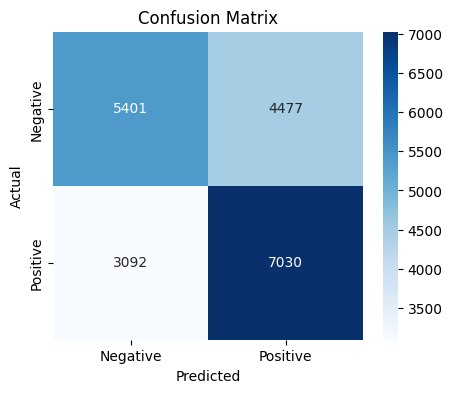

CPU times: user 11.3 s, sys: 221 ms, total: 11.5 s
Wall time: 3.57 s


In [63]:
%%time
# HistGradientBoostingClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


hgbc_model = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_iter=100,
    max_depth=5,
    l2_regularization=1.0,
    early_stopping=True
)

hgbc_model.fit(X_train, y_train)


y_pred_proba = hgbc_model.predict_proba(X_test)[:, 1]  # Get probability scores
y_pred_binary_hgbc = (y_pred_proba >= 0.5).astype(int)  # Convert probabilities to 0/1


accuracy = accuracy_score(y_test, y_pred_binary_hgbc)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_binary_hgbc))

cm = confusion_matrix(y_test, y_pred_binary_hgbc)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()




Accuracy: 0.60135

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.51      0.56      9878
           1       0.59      0.69      0.64     10122

    accuracy                           0.60     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.60      0.60      0.60     20000


Top 10 Most Important Features:
                          feature  importance
4   NumAntivirusProductsInstalled    0.185471
32   PrimaryDisplayDiagonalInches    0.088375
3               AntivirusConfigID    0.069559
80             EngineVersion_freq    0.062990
41                  OSInstallType    0.050193
82          SignatureVersion_freq    0.032317
81                AppVersion_freq    0.028740
30             TotalPhysicalRAMMB    0.024296
67                   AS_month_cos    0.022063
26               ProcessorModelID    0.021991


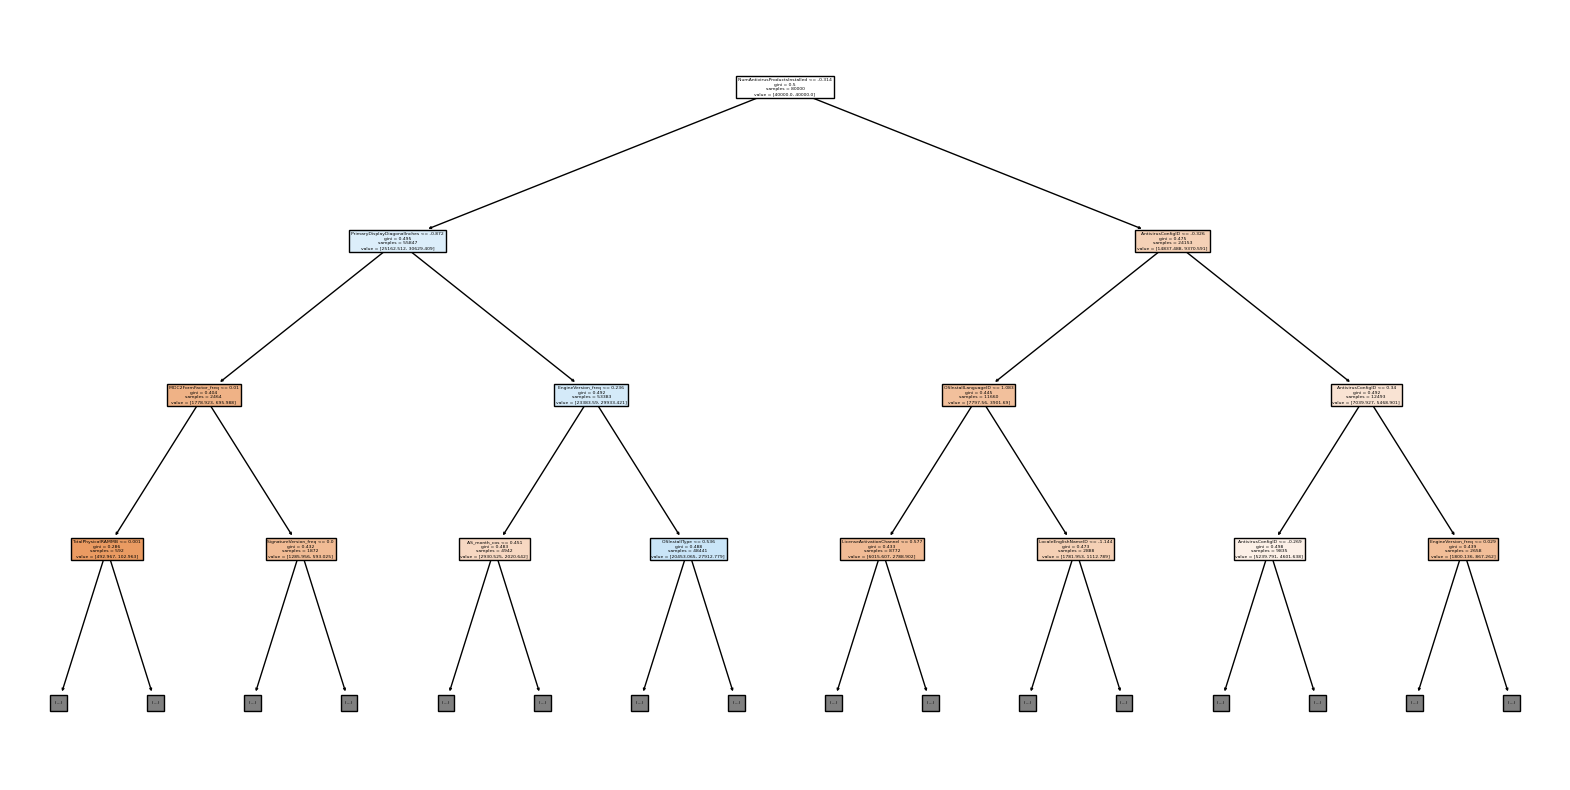

CPU times: user 3.28 s, sys: 175 ms, total: 3.46 s
Wall time: 3.24 s


In [64]:
%%time
# DecisionTreeClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_model = DecisionTreeClassifier(
    max_depth=10,              # Preventing overfitting
    min_samples_split=10,     
    min_samples_leaf=5,       
    random_state=42,
    class_weight='balanced'    # Handles class imbalance
)


dt_model.fit(X_train, y_train)


y_pred = dt_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)


print("\nClassification Report:")
print(classification_report(y_test, y_pred))


feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_model.feature_importances_
})

print("\nTop 10 Most Important Features:")
print(feature_importance.sort_values('importance', ascending=False).head(10))


plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns, filled=True, max_depth=3)
plt.show()


In [65]:
%%time
# RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_final = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=20,
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)


rf_final.fit(X_train, y_train)


y_pred_final_rf = rf_final.predict(X_test)

print("\nRandom Forest - Final Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_final_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final_rf))




Random Forest - Final Model Evaluation:
Accuracy: 0.62645

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.59      0.61      9878
           1       0.62      0.66      0.64     10122

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000

CPU times: user 58.4 s, sys: 29.7 ms, total: 58.5 s
Wall time: 58.8 s


In [18]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


xgb_params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'auc',  
    'booster': 'gbtree',  # Use tree-based model
    'max_depth': 6,  # Limits tree depth to prevent overfitting
    'learning_rate': 0.1,  # Faster learning rate
    'n_estimators': 100,  # Number of trees
    'subsample': 0.8,  # Uses 80% of data per tree
    'colsample_bytree': 0.7,  # Uses 70% of features per tree
    'lambda': 1,  # L2 Regularization
    'alpha': 0.5,  # L1 Regularization
    'random_state': 42
}


xgb_model = xgb.XGBClassifier(**xgb_params)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=False 
)


y_pred = xgb_model.predict_proba(X_test)[:, 1]  
y_pred_binary_xgb = (y_pred >= 0.5).astype(int)  # Convert probabilities to 0/1


accuracy = accuracy_score(y_test, y_pred_binary_xgb)
print("✅ XGBoost Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_binary_xgb))


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


✅ XGBoost Accuracy: 0.62825
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.58      0.60      9878
           1       0.62      0.68      0.65     10122

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000

CPU times: user 12.7 s, sys: 247 ms, total: 13 s
Wall time: 4.1 s


In [72]:
%%time
xgb_temp = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='auc', 
    n_estimators=100, max_depth=5, use_label_encoder=False
)
xgb_temp.fit(X_train, y_train)

feature_importances = xgb_temp.feature_importances_


N = 45  
top_features = np.argsort(feature_importances)[-N:]  


X_train_selected = X_train.iloc[:, top_features]
X_test_selected = X_test.iloc[:, top_features]


xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05)
xgb_model.fit(X_train_selected, y_train)


y_pred = xgb_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)

print("✅ XGBoost Accuracy after Feature Selection:", accuracy)


✅ XGBoost Accuracy after Feature Selection: 0.6283
CPU times: user 12 s, sys: 247 ms, total: 12.3 s
Wall time: 3.88 s


In [73]:
print("LGBM:\n", classification_report(y_test, y_pred_binary_lgb))
print("Random Forest:\n", classification_report(y_test, y_pred_final_rf))
print("XGBoost:\n", classification_report(y_test, y_pred_binary_xgb))
print("HGBC:\n", classification_report(y_test, y_pred_binary_hgbc))



LGBM:
               precision    recall  f1-score   support

           0       0.64      0.57      0.60      9878
           1       0.62      0.68      0.65     10122

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000

Random Forest:
               precision    recall  f1-score   support

           0       0.63      0.59      0.61      9878
           1       0.62      0.66      0.64     10122

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000

XGBoost:
               precision    recall  f1-score   support

           0       0.64      0.58      0.60      9878
           1       0.62      0.68      0.65     10122

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.

1. LGBM and XGBoost perform the best overall.

2. HGBC has better recall (captures more positives but sacrifices precision).

3. Random Forest is slightly more balanced but doesn't outperform the others.

# Hyperparameter Tuning

In [74]:
# Step 1: Standardize the Data (PCA needs scaled data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA (Keep 95% Variance)
pca = PCA(n_components=0.95)  # Keeps 95% of variance
X_pca = pca.fit_transform(X_scaled)

print(f"✅ Reduced from {X.shape[1]} to {X_pca.shape[1]} dimensions")


✅ Reduced from 88 to 59 dimensions


In [20]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],
    'boosting_type': 'gbdt',
    'num_leaves': 120,  
    'learning_rate': 0.015,  
    'max_depth': -1,  
    'min_data_in_leaf': 60,  
    'min_gain_to_split': 0.01,  
    'feature_fraction': 0.75,  
    'bagging_fraction': 0.75,  
    'bagging_freq': 1,  
    'lambda_l1': 4.0,  
    'lambda_l2': 5.0,  
    'max_bin': 255,  
    'verbosity': -1,  
    'n_jobs': -1  
}

lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_eval],
    num_boost_round=1500,  
    callbacks=[
        lgb.early_stopping(100),  
        lgb.log_evaluation(100)  
    ]
)

y_pred = lgb_model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
auc_score = roc_auc_score(y_test, y_pred)

print("Final Enhanced Model Accuracy:", accuracy)
print("Final AUC Score:", auc_score)

# ✅ Print the best parameters used
print("Best Parameters:", lgb_model.params)


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.671678	valid_0's binary_logloss: 0.653335
[200]	valid_0's auc: 0.676124	valid_0's binary_logloss: 0.645878
[300]	valid_0's auc: 0.679003	valid_0's binary_logloss: 0.643054
[400]	valid_0's auc: 0.680439	valid_0's binary_logloss: 0.641792
[500]	valid_0's auc: 0.681051	valid_0's binary_logloss: 0.641254
[600]	valid_0's auc: 0.681461	valid_0's binary_logloss: 0.640957
[700]	valid_0's auc: 0.681339	valid_0's binary_logloss: 0.640996
Early stopping, best iteration is:
[624]	valid_0's auc: 0.681522	valid_0's binary_logloss: 0.640923
Final Enhanced Model Accuracy: 0.62995
Final AUC Score: 0.6815216076760866
Best Parameters: {'objective': 'binary', 'metric': ['auc', 'binary_logloss'], 'boosting_type': 'gbdt', 'num_leaves': 120, 'learning_rate': 0.015, 'max_depth': -1, 'min_data_in_leaf': 60, 'min_gain_to_split': 0.01, 'feature_fraction': 0.75, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'lambda_l1': 4.0, 'lamb

In [76]:
%%time

#  takes much time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'num_leaves': [20, 31, 50, 70, 100],   # Model complexity
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size
    'n_estimators': [100, 200, 300],    # Number of boosting rounds
    'min_child_samples': [10, 20, 30, 50],  # Min samples in leaf
    'reg_alpha': [0, 0.1, 0.5],   # L1 regularization
    'reg_lambda': [0, 0.1, 0.5]   # L2 regularization
}

# Initialize LightGBM model
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=42)

# RandomizedSearchCV for faster tuning
random_search = RandomizedSearchCV(
    lgb_model, param_distributions=param_dist,
    n_iter=10,  # Number of different combinations to try
    scoring='accuracy',  # Optimize for accuracy
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all CPU cores
)

# Fit the model
random_search.fit(X_train, y_train)

# Get best parameters
best_params = random_search.best_params_
print(f"\n✅ Best Hyperparameters: {best_params}")

# Train best model
best_lgb = lgb.LGBMClassifier(**best_params, random_state=42)
best_lgb.fit(X_train, y_train)

# Predictions
y_pred = best_lgb.predict(X_test)
final_acc = accuracy_score(y_test, y_pred)
final_auc = roc_auc_score(y_test, best_lgb.predict_proba(X_test)[:, 1])

print("✅ Tuned LightGBM Accuracy:", final_acc)
print("✅ Tuned LightGBM AUC Score:", final_auc)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ Best Hyperparameters: {'reg_lambda': 0, 'reg_alpha': 0.5, 'num_leaves': 70, 'n_estimators': 300, 'min_child_samples': 30, 'learning_rate': 0.05}
✅ Tuned LightGBM Accuracy: 0.62745
✅ Tuned LightGBM AUC Score: 0.6785700783704647
CPU times: user 25 s, sys: 805 ms, total: 25.8 s
Wall time: 2min 36s


In [77]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [4, 6],  
    'learning_rate': [0.05, 0.1],  
    'n_estimators': [100, 300],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0],  
    'lambda': [1, 5],  
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

# Use `cv=2` instead of `cv=1`
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=10,  
    scoring='roc_auc',
    cv=2,  
    n_jobs=-1,  
    verbose=1  
)

# Fit the model
random_search.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=False
)

# Get best model
best_xgb = random_search.best_estimator_

# Predict
y_pred = best_xgb.predict_proba(X_test)[:, 1]
y_pred_binary = (y_pred >= 0.5).astype(int)

# Evaluate
accuracy = accuracy_score(y_test, y_pred_binary)
auc_score = roc_auc_score(y_test, y_pred)

print("✅ Best Hyperparameters:", random_search.best_params_)
print("✅ Tuned XGBoost Accuracy:", accuracy)
print("✅ Tuned XGBoost AUC Score:", auc_score)


Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


✅ Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'lambda': 1, 'colsample_bytree': 0.8}
✅ Tuned XGBoost Accuracy: 0.62755
✅ Tuned XGBoost AUC Score: 0.6758199990486584
CPU times: user 18.3 s, sys: 452 ms, total: 18.7 s
Wall time: 1min 3s


In [78]:
%%time 


# Pca

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # More granularity in `C`
    'solver': ['liblinear', 'lbfgs']  # Stick to effective solvers
}

# Initialize model
log_reg = LogisticRegression(penalty='l2', random_state=42, max_iter=200)

# Use **GridSearchCV** for better tuning
grid_search = GridSearchCV(
    log_reg,
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1, 
    verbose=1
)

# Fit model
grid_search.fit(X_train, y_train)

# Best model
best_log_reg = grid_search.best_estimator_

# Predict
y_pred = best_log_reg.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, best_log_reg.predict_proba(X_test)[:, 1])

print("✅ Best Hyperparameters:", grid_search.best_params_)
print("✅ Tuned Logistic Regression Accuracy:", accuracy)
print("✅ Tuned Logistic Regression AUC Score:", auc_score)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best Hyperparameters: {'C': 10, 'solver': 'lbfgs'}
✅ Tuned Logistic Regression Accuracy: 0.60765
✅ Tuned Logistic Regression AUC Score: 0.6430303386356025
CPU times: user 1.08 s, sys: 425 ms, total: 1.51 s
Wall time: 9.28 s


# Making Predictions & Deployment

In [66]:
test_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

test_df.drop(columns=columns_to_drop, inplace=True)

# Convert dates and extract features
test_df['DateAS'] = pd.to_datetime(test_df['DateAS'])
test_df['DateOS'] = pd.to_datetime(test_df['DateOS'])
test_df['AS_year'] = test_df['DateAS'].dt.year
test_df['AS_month'] = test_df['DateAS'].dt.month
test_df['AS_day'] = test_df['DateAS'].dt.day
test_df['AS_hour'] = test_df['DateAS'].dt.hour
test_df['AS_dayofweek'] = test_df['DateAS'].dt.dayofweek

test_df['OS_year'] = test_df['DateOS'].dt.year
test_df['OS_month'] = test_df['DateOS'].dt.month
test_df['OS_day'] = test_df['DateOS'].dt.day

# Compute time difference in days
test_df['days_diff'] = (test_df['DateAS'] - test_df['DateOS']).dt.days

# Apply cyclical encoding for months and days
test_df['AS_month_sin'] = np.sin(2 * np.pi * test_df['AS_month'] / 12)
test_df['AS_month_cos'] = np.cos(2 * np.pi * test_df['AS_month'] / 12)
test_df['AS_day_sin'] = np.sin(2 * np.pi * test_df['AS_day'] / 31)
test_df['AS_day_cos'] = np.cos(2 * np.pi * test_df['AS_day'] / 31)

# Drop original date columns
test_df.drop(columns=['DateAS', 'DateOS'], inplace=True)

# Impute missing values
test_df[numerical_cols] = num_imputer.transform(test_df[numerical_cols])
test_df[categorical_cols] = cat_imputer.transform(test_df[categorical_cols])

# Scale numerical features
test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])

# Encode categorical variables
for col in binary_cols:
    test_df[col] = test_df[col].astype('category').cat.codes

test_df = pd.get_dummies(test_df, columns=low_cardinality_cols, drop_first=True)
test_df[medium_cardinality_cols] = encoder.transform(test_df[medium_cardinality_cols])

for col in high_cardinality_cols:
    test_df[col + '_freq'] = test_df[col].map(test_df[col].value_counts() / len(test_df))

test_df.drop(columns=high_cardinality_cols, inplace=True)

print("✅ Test data preprocessing completed!")


✅ Test data preprocessing completed!


In [67]:
# Predict probabilities
y_pred = lgb_model.predict(test_df)
y_pred_binary = (y_pred >= 0.5).astype(int)  # Convert probabilities to 0/1

print("✅ Predictions completed!")


✅ Predictions completed!


In [68]:
submission = sample_submission_df.copy()
submission['target'] = y_pred_binary  

# Save to CSV
submission.to_csv('./submission.csv', index=False)

print("✅ Submission file 'submission.csv' created successfully!")


✅ Submission file 'submission.csv' created successfully!


In [69]:
submission["target"].value_counts()

target
1    5270
0    4730
Name: count, dtype: int64

In [70]:
print("File exists:", os.path.exists("submission.csv"))

File exists: True
